# Clean Notebook

Todo:
- Copy Code from midterm
- write loop
- write function
- clean up

## Maggie's Stuff

In [ ]:
# MAGGIE MAGGIE MAGGIE

## Seth's Landcover Stuff

In [ ]:
#import necessary packages
# Rasterio documentation can be found at https://rasterio.readthedocs.io/en/latest/

import numpy as np
import rasterio
import rasterio.plot
import pandas as pd


# import plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import contextily as ctx

years = [2004, 2019] # create a list of the comparison years to loop over
data = {} # Create an empty dictionary to save the raster dataset to 
data_masked = {} # Create empty dictionary to save masked numpy array to

#Loop through years specified to create data needed to plot
for year in years:
    data[year] = rasterio.open(f'data/NLCD/NLCD_{str(year)}_Land_Cover_L48_20210604_gyGbthZM9gweVLuKaW5e.tiff') # open raster and create element in 'data' dict.
    data_masked[year] = np.ma.masked_where(data[year].read(1)!=11, data[year].read(1)) # mask raster to show only were data is '11' (Open Water)


# ### Mapping Change in Water Cover
# 
# Now that we have our data prepared and masked we can overlay the 2004 and 2019 data we can overlay them to highlight the areas where there used to be water but is now dry lakebed.

# %%
fig, ax = plt.subplots(figsize=(15,10)) # create a figure and axis object to map onto and set the figure size.
plt.imshow(data_masked[years[1]], extent=rasterio.plot.plotting_extent(data[years[1]]), cmap=ListedColormap(['blue']), zorder= 15) #plot data, set extent to geography, set color and drawing order
plt.imshow(data_masked[years[0]], extent=rasterio.plot.plotting_extent(data[years[0]]), cmap=ListedColormap(['red']), zorder= 10)

# creates legend items
handles = [
    Patch(color='red', label='2004 Water Area'),
    Patch(color='blue', label='2019 Water Area')
]

ctx.add_basemap(ax, crs=dataset_2019.read_crs(), source=ctx.providers.Esri.WorldImagery, zorder=5)
plt.axis('off')
plt.title('2004 and 2019 Open Water Area')
ax.legend(handles=handles)

plt.show()

# %% [markdown]
# This highlights the significant change in water area of the Salton Sea over this time period, but can we quantify it? 
# 
# We can with some numpy calculations! The individual pixel/cell size from NLCD is 30m by 30m, and we can count the number of cells of water in each year and calculate the difference.

# %%
count_19 = np.count_nonzero(data[2019].read(1) == 11)
count_04 = np.count_nonzero(data[2004].read(1) == 11)

sq_km = (count_04 - count_19)*900/1e6

print(f'The area surface area of water lost between 2004 and 2019 was {sq_km} square kilometers.')

# %% [markdown]
# That doesn't sound like a ton off the bat, but in perspective that is 12,793 football fields of area! That is a ton of water lost, and a ton of exposed dust and desert.
# 
# Now let's make a graph to see the land cover area for all categories side by side.

# %%
# Open the data dictionary and save it as a normal python dictionary for 

data_dict = pd.read_csv('data/NLCD/NLCD_landcover_legend_2018_12_17_gyGbthZM9gweVLuKaW5e.csv')
data_dict.dropna(axis=0, inplace=True) # Drop values with no legend information
legend = dict(zip(data_dict['Value'], data_dict['Legend'])) # save values and legend item as a dictionary for ease of use later.

# %%
# Create numpy arrays that are labeled instead of just as integers
labeled_data = {} #create an empty dict to fill
for year in years:
    labeled_data[year] = np.vectorize(legend.get)(data[year].read(1)) # fill dict item with np array where elements are labeled strings

# %%
# count cells of each land cover type for each year
counts_04 = np.unique(labeled_data[2004], return_counts=True)
counts_19 = np.unique(labeled_data[2019], return_counts=True)

# %%
# Create dataframe with landcover type and count for each year
df = pd.DataFrame(list(zip(counts_04[0],counts_04[1], counts_19[1])), columns=['landcover', '2004', '2019']) 
df['2004'] = df['2004']*900/1e6 # calculate as area in sq km
df['2019'] = df['2019']*900/1e6
df.head()

# %%
df_long = pd.melt(df, id_vars='landcover', value_vars=['2004','2019']) # convert to a "long" data frame that is better for plotting side by side

# %%
# Plot the land cover area as a bar chart side by side
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,10))

sns.barplot( 
    ax=ax, data=df_long,
    x='landcover', y='value', hue='variable',
    palette='dark', alpha=.6,
)
plt.xlabel('Land Cover', fontsize=12)
plt.ylabel('Area of Land (square km)', fontsize=12)
plt.xticks(rotation=45)
ax.get_xaxis

## Miriam's Stuff

## Tiffany's Stuff

## Exploring the proportion of land that is considered to be in a drought in Imperial, San Diego & Riverside County
## Data was obtained from US Drought Monitoring System

First, I will import all the libraries I may need in the notebook

In [1]:
# import libraries
import geopandas as gpd
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import contextily as ctx

Next I upload my data, and inspect it to ensure that it has loaded properly.

In [3]:
countydf=pd.read_csv('data/Drought/2018_2022Drought.csv')
countydf.sample(10)

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,ValidStart,ValidEnd,StatisticFormatID
158,20200211,6025,Imperial County,CA,100.00,0.00,0.00,0.00,0.00,0.0,2/11/20,2/17/20,1
179,20190917,6025,Imperial County,CA,9.55,90.45,31.87,0.00,0.00,0.0,9/17/19,9/23/19,1
580,20220125,6073,San Diego County,CA,0.00,100.00,100.00,0.00,0.00,0.0,1/25/22,1/31/22,1
305,20220426,6065,Riverside County,CA,0.00,100.00,100.00,69.36,0.24,0.0,4/26/22,5/2/22,1
638,20201215,6073,San Diego County,CA,0.00,100.00,4.80,0.00,0.00,0.0,12/15/20,12/21/20,1
44,20220419,6025,Imperial County,CA,0.00,100.00,100.00,100.00,0.00,0.0,4/19/22,4/25/22,1
417,20200303,6065,Riverside County,CA,100.00,0.00,0.00,0.00,0.00,0.0,3/3/20,3/9/20,1
507,20180612,6065,Riverside County,CA,0.00,100.00,100.00,98.14,12.76,0.0,6/12/18,6/18/18,1
608,20210713,6073,San Diego County,CA,0.00,100.00,100.00,10.81,0.00,0.0,7/13/21,7/19/21,1
364,20210309,6065,Riverside County,CA,0.00,100.00,99.94,54.49,18.93,0.0,3/9/21,3/15/21,1


I am now creating a function that contains three loops. First, I create a list of all unique values for my "County" column. Next, I will loop through each county name, and create a new data frame for each county containing values for the five levels of drought. Lastly, I will create a plot containing one drought level at a time.

In [4]:

def loop_plot(countydf,list_columns,countyname,x_axe):
    # returning a list of name of each county
    county = countydf[countyname].unique()
    # looping throuth each county name and create a new dataframe
    for x in county:
        x = countydf.loc[countydf[countyname] == x]
        # looping through the columns D0, D1 ... and plot line for each column
        for column in list_columns:
            x.plot(x=x_axe,y = column ,figsize=(10, 5), grid=True)

In order for my function to work, I must define list_columns. Here, I create a list of all the drought levels. In the next line, I instruct the function to plot the different drought levels by county, using the start date for that drought level as the x axis. The loop will yield 5 graphs for each county.

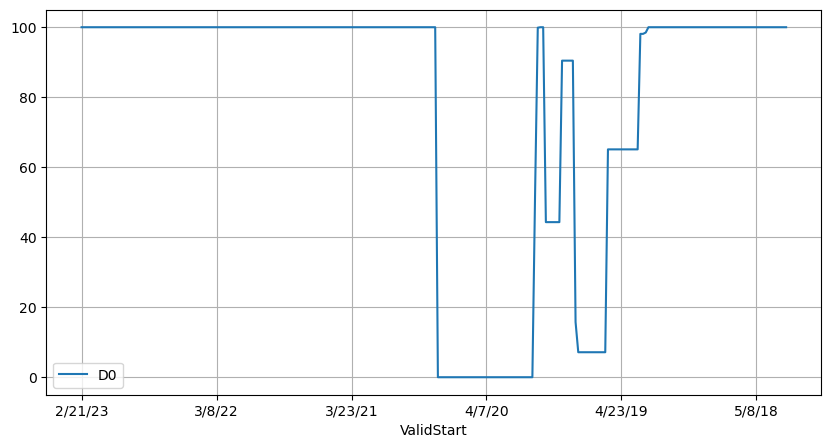

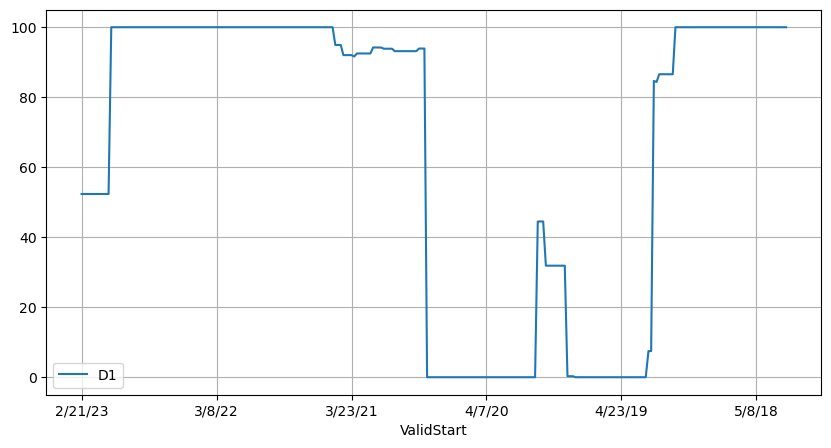

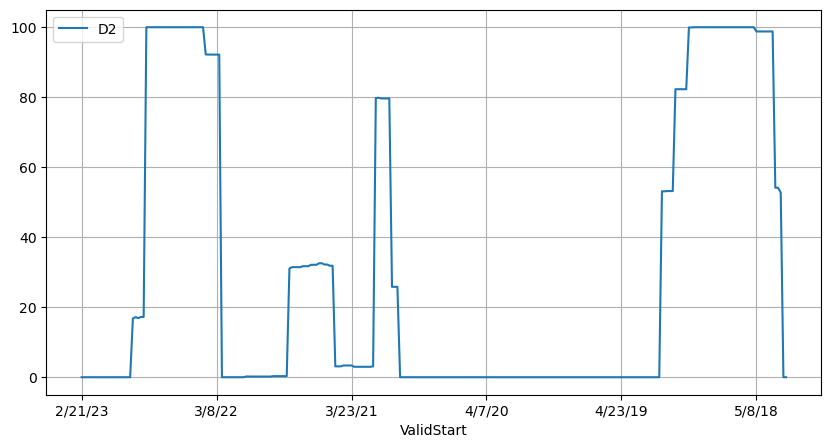

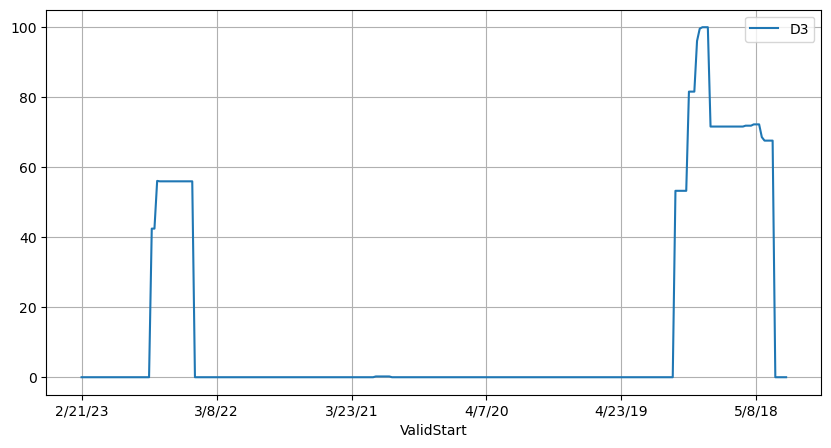

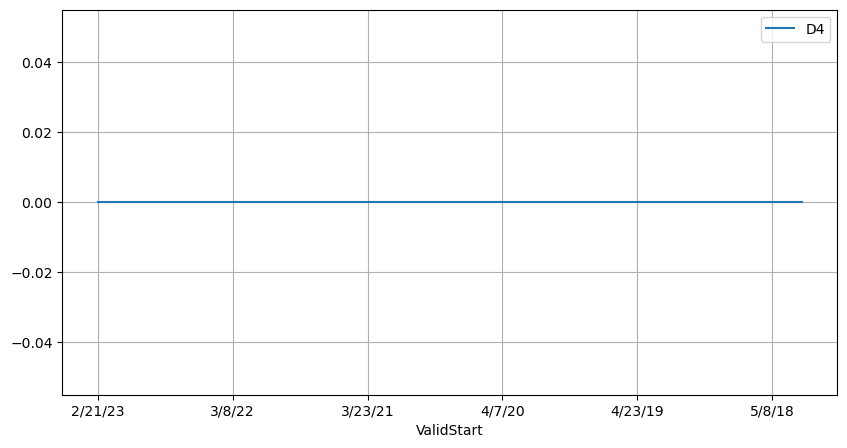

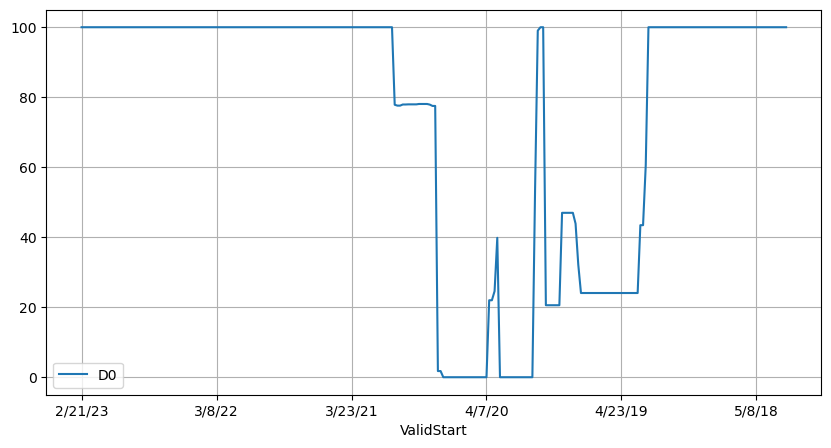

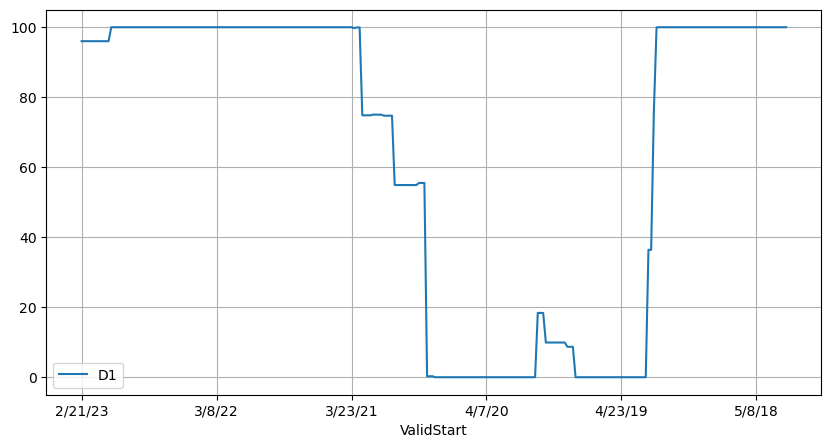

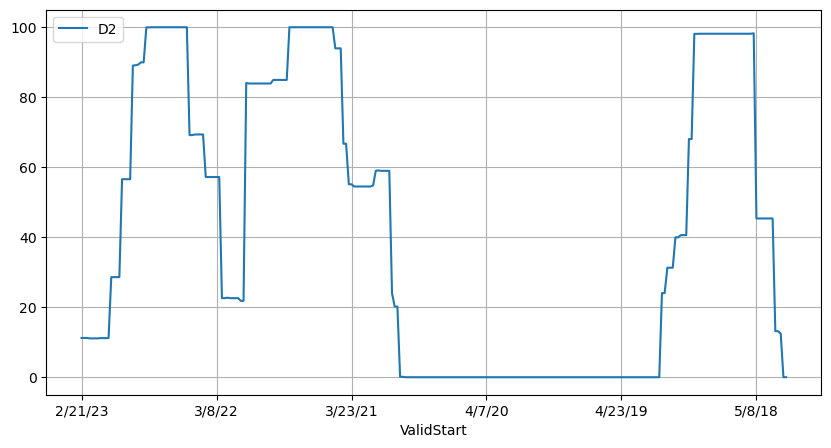

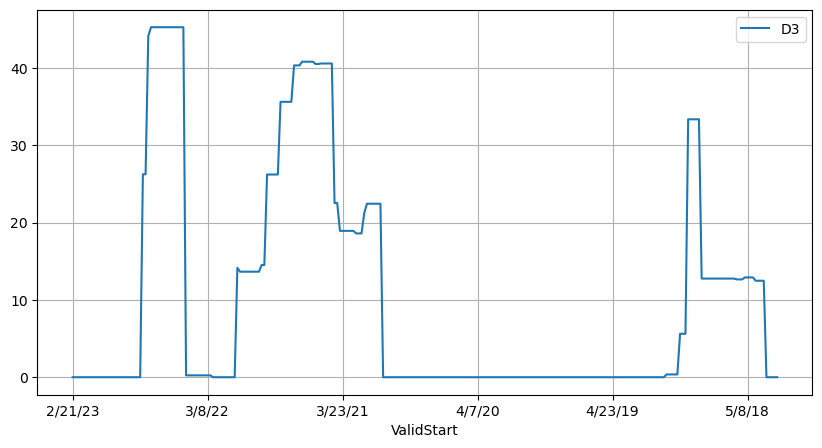

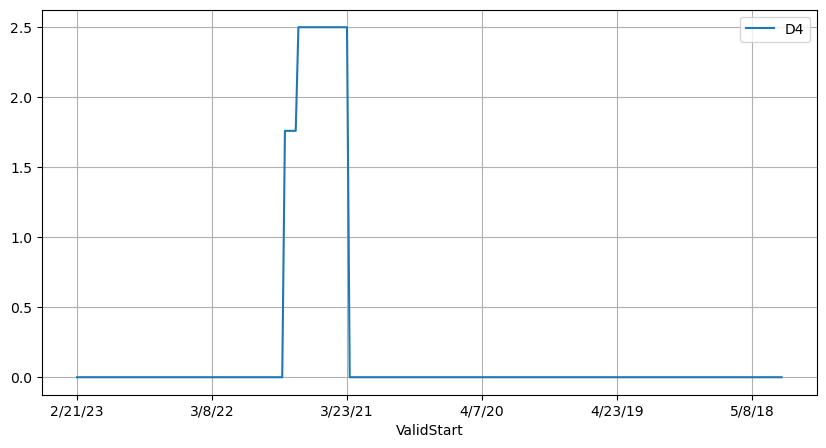

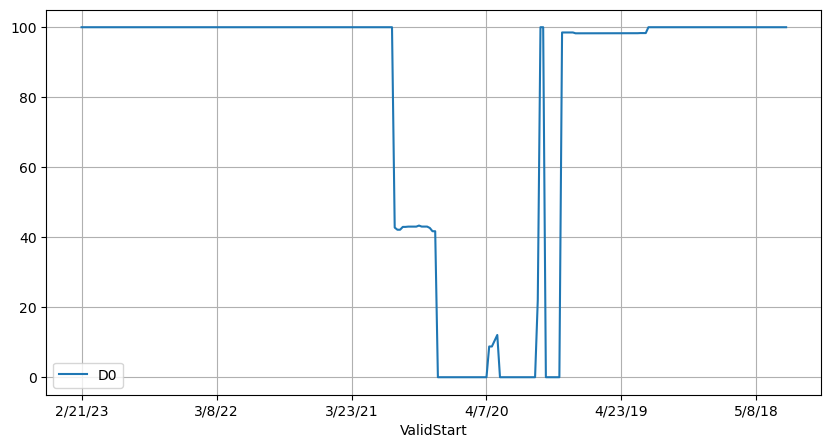

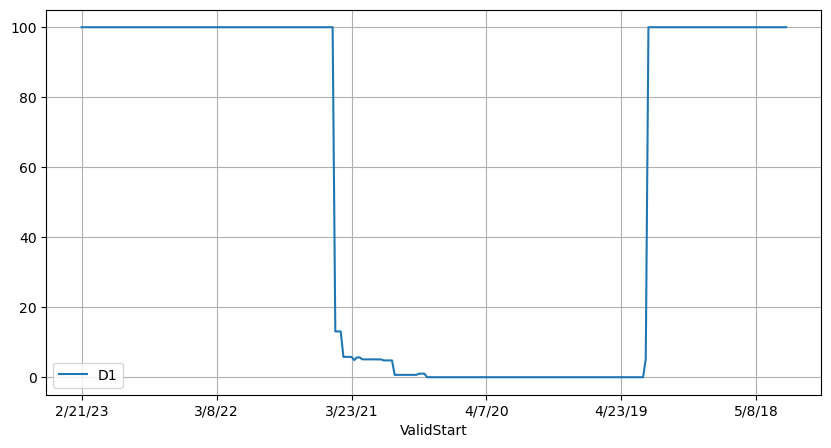

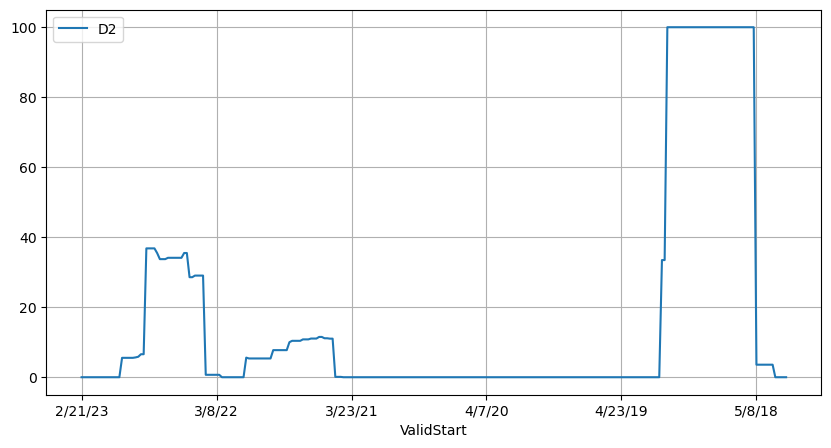

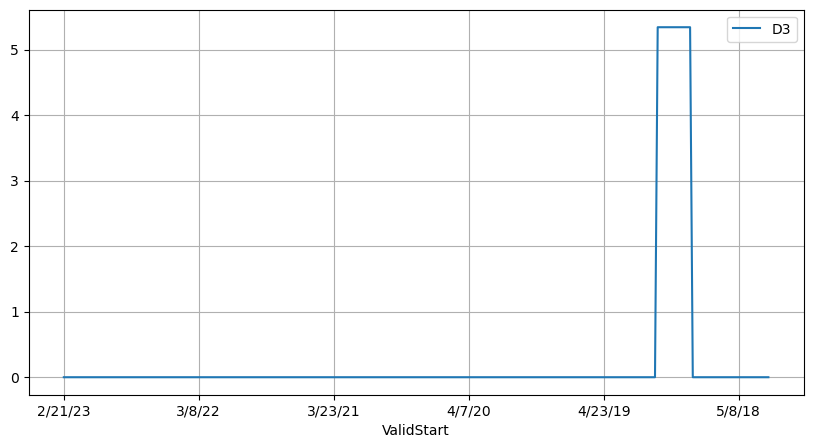

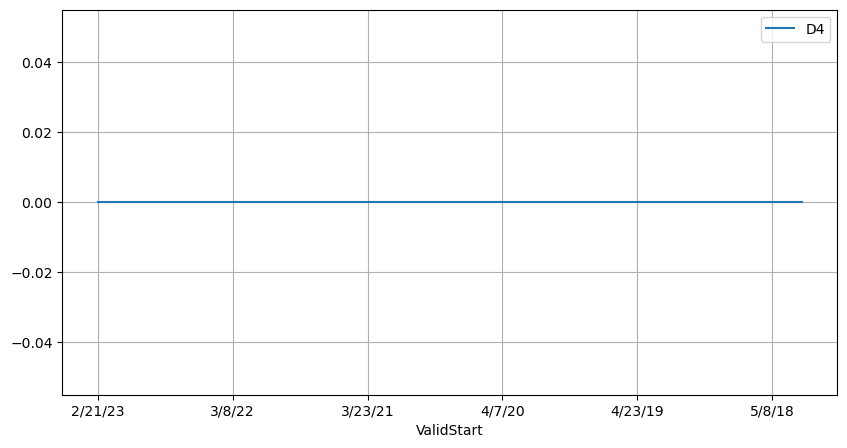

In [5]:
list_columns = ['D0','D1','D2','D3','D4']
loop_plot(countydf,list_columns,'County','ValidStart')